In [198]:
%pylab inline
from astropy.table import Table
from rnn import RNNClassifier
import tensorflow as tf
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [199]:
# Loading dataset
#data_table = Table.read('normalized_sub_mean.fits')
data_table = Table.read('normalized_good.fits')

In [200]:
data_table

FILENAME,SURVEY,SNID,SNTYPE,FILTERS,RA,DECL,FAKE,MWEBV,REDSHIFT_SPE,NOBS,NVAR,"DATA [50,9]",obs_length,num_data_points
bytes16,bytes7,bytes12,bytes5,bytes6,bytes21,bytes20,bytes35,bytes23,bytes25,bytes5,bytes3,float64,float64,int64
DES_SN000018.DAT,DES,18,-9,griz,34.500000 deg,-5.500000 deg,3 (=> BLIND-TEST simulation),0.0227 MW E(B-V),-9.0000 +- 9.0000,118,5,0.0 .. 0.0,145.8949999999968,41
DES_SN000050.DAT,DES,50,-9,griz,36.750000 deg,-4.500000 deg,3 (=> BLIND-TEST simulation),0.0283 MW E(B-V),-9.0000 +- 9.0000,16,5,0.0 .. 0.0,30.93000000000029,9
DES_SN000051.DAT,DES,51,1,griz,52.500000 deg,-27.500000 deg,3 (=> BLIND-TEST simulation),0.0097 MW E(B-V),0.5177 +- 0.0050,121,5,0.0 .. 0.0,126.88300000000163,33
DES_SN000063.DAT,DES,63,-9,griz,34.500000 deg,-5.500000 deg,3 (=> BLIND-TEST simulation),0.0227 MW E(B-V),-9.0000 +- 9.0000,115,5,0.0 .. 0.0,127.9409999999989,37
DES_SN000064.DAT,DES,64,-9,griz,48.000000 deg,0.000000 deg,3 (=> BLIND-TEST simulation),0.0713 MW E(B-V),-9.0000 +- 9.0000,92,5,0.0 .. 0.0,117.89800000000105,31
DES_SN000096.DAT,DES,96,-9,griz,34.500000 deg,-5.500000 deg,3 (=> BLIND-TEST simulation),0.0227 MW E(B-V),-9.0000 +- 9.0000,104,5,0.0 .. 0.0,119.87900000000081,37
DES_SN000122.DAT,DES,122,-9,griz,34.500000 deg,-5.500000 deg,3 (=> BLIND-TEST simulation),0.0227 MW E(B-V),-9.0000 +- 9.0000,11,5,0.0 .. 0.0,17.95300000000134,7
DES_SN000124.DAT,DES,124,-9,griz,48.000000 deg,0.000000 deg,3 (=> BLIND-TEST simulation),0.0713 MW E(B-V),-9.0000 +- 9.0000,95,5,0.0 .. 0.0,113.96500000000378,34
DES_SN000156.DAT,DES,156,-9,griz,36.750000 deg,-4.500000 deg,3 (=> BLIND-TEST simulation),0.0283 MW E(B-V),-9.0000 +- 9.0000,87,5,0.0 .. 0.0,96.0309999999954,25


In [3]:
# Splitting training and testing data
np.random.seed(1234)
randomize_inds = range(len(data_table))
randomize_inds = permutation(randomize_inds)
randomized_inds_train = randomize_inds[0:15000]
randomized_inds_test  = randomize_inds[15000:]

In [4]:
data_table['label'] = 1.0*(data_table['SNTYPE'].astype('int') == 1)

In [5]:
# Define input function for training 
def input_fn_train():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_train[inds]
            return data_table['label'][inds].astype('float32'), clip(data_table['num_data_points'][inds],0,49).astype('int32'),data_table['DATA'][inds].astype('float32') 
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,50,9])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_train))
    dataset = dataset.repeat().shuffle(10000).batch(512)
    dataset = dataset.map( mapping_function)
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

def input_fn_train_test():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_train[inds]
            return data_table['label'][inds].astype('float32'), clip(data_table['num_data_points'][inds],0,49).astype('int32'),data_table['DATA'][inds].astype('float32')
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,50,9])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_train))
    dataset = dataset.batch(512)
    dataset = dataset.map( mapping_function)
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

def input_fn_test():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_test[inds]
            return data_table['label'][inds].astype('float32'), clip(data_table['num_data_points'][inds],0,49).astype('int32'),data_table['DATA'][inds].astype('float32') 
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,50,9])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_test))
    dataset = dataset.batch(512)
    dataset = dataset.map( mapping_function)
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

In [6]:
#model = RNNClassifier(hidden_units=[128, 128], dropout=1, model_dir='tests/test_1')
#model = RNNClassifier(hidden_units=[128, 128], dropout=0.8, model_dir='tests/test_2')
model = RNNClassifier(hidden_units=[128, 128], dropout=0.8, model_dir='tests/test_6')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tests/test_5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1214bbf28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [7]:
#model.train(input_fn=input_fn_train, steps=10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into tests/test_4/model.ckpt.
INFO:tensorflow:loss = 0.691672, step = 0
INFO:tensorflow:global_step/sec: 16.9999
INFO:tensorflow:loss = 0.5060076, step = 100 (5.884 sec)
INFO:tensorflow:global_step/sec: 17.6129
INFO:tensorflow:loss = 0.23769264, step = 200 (5.678 sec)
INFO:tensorflow:global_step/sec: 17.5954
INFO:tensorflow:loss = 0.1952594, step = 300 (5.683 sec)
INFO:tensorflow:global_step/sec: 17.5843
INFO:tensorflow:loss = 0.21994564, step = 400 (5.687 sec)
INFO:tensorflow:global_step/sec: 17.6138
INFO:tensorflow:loss = 0.18144815, step = 500 (5.677 sec)
INFO:tensorflow:global_step/sec: 17.6273
INFO:tensorflow:loss = 0.1888588, step = 600 (5.673 sec)
INFO:tensorflow:global_step/sec: 17.6585
INFO:tensorflow:lo

INFO:tensorflow:global_step/sec: 17.6343
INFO:tensorflow:loss = 0.14173366, step = 8000 (5.671 sec)
INFO:tensorflow:global_step/sec: 17.6389
INFO:tensorflow:loss = 0.107688025, step = 8100 (5.669 sec)
INFO:tensorflow:global_step/sec: 17.6835
INFO:tensorflow:loss = 0.12958519, step = 8200 (5.655 sec)
INFO:tensorflow:global_step/sec: 17.6531
INFO:tensorflow:loss = 0.13616973, step = 8300 (5.665 sec)
INFO:tensorflow:global_step/sec: 17.6072
INFO:tensorflow:loss = 0.110651605, step = 8400 (5.680 sec)
INFO:tensorflow:global_step/sec: 17.6743
INFO:tensorflow:loss = 0.12912667, step = 8500 (5.658 sec)
INFO:tensorflow:global_step/sec: 17.6172
INFO:tensorflow:loss = 0.13393885, step = 8600 (5.676 sec)
INFO:tensorflow:global_step/sec: 17.6219
INFO:tensorflow:loss = 0.10502879, step = 8700 (5.675 sec)
INFO:tensorflow:global_step/sec: 17.6563
INFO:tensorflow:loss = 0.11904025, step = 8800 (5.664 sec)
INFO:tensorflow:global_step/sec: 17.5821
INFO:tensorflow:loss = 0.11658929, step = 8900 (5.688 sec

In [7]:
# Apply model to test set
test_prob = [p['prob'] for p in model.predict(input_fn_test)]
table_test = data_table[randomized_inds_test]
table_test['p'] = test_prob

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tests/test_5/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [8]:
# Apply model to training set
train_prob = [p['prob'] for p in model.predict(input_fn_train_test)]
table_train = data_table[randomized_inds_train]
table_train['p'] = train_prob

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tests/test_5/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


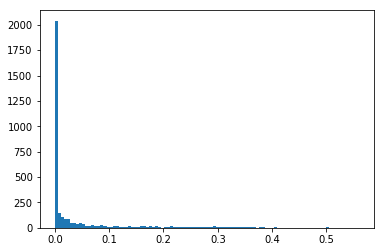

In [9]:
hist(test_prob,100);

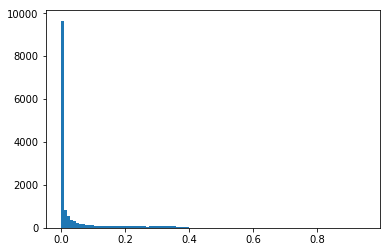

In [10]:
hist(train_prob,100);

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(0, 1)

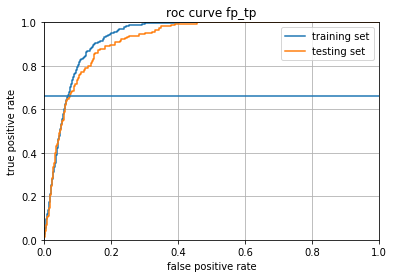

In [11]:
# Compute ROC curves 
from sklearn.metrics import roc_curve

fpr1, tpr1, thr1 = roc_curve(table_train['label'], table_train['p'])
fpr2, tpr2, thr2 = roc_curve(table_test['label'], table_test['p'])

plot(fpr1, tpr1,label='training set')
plot(fpr2, tpr2,label='testing set')
title("roc curve fp_tp")
xlabel('false positive rate')
ylabel('true positive rate')
grid('on')
#xscale('log')
legend()
axhline(0.661)
xlim(0,1)
ylim(0,1)

In [12]:
from sklearn.metrics import roc_auc_score

In [13]:
roc_auc_score(table_train['label'], table_train['p'])

0.9332666419051011

In [14]:
roc_auc_score(table_test['label'], table_test['p'])

0.9186332209588024

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


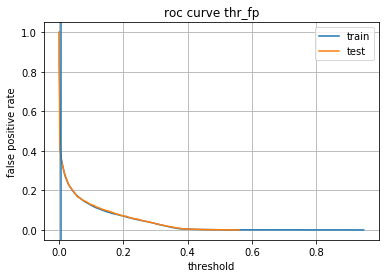

In [15]:
plot(thr1,fpr1,label='train')
plot(thr2, fpr2,label='test')
title("roc curve thr_fp")
xlabel('threshold')
ylabel('false positive rate')
grid('on')
legend()
axvline(0.0043)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


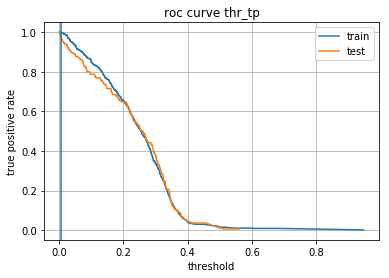

In [16]:
plot(thr1,tpr1,label='train')
plot(thr2, tpr2,label='test')
title("roc curve thr_tp")
xlabel('threshold')
ylabel('true positive rate')
grid('on')
legend()
axvline(0.0043)

In [100]:
threshold=0.083
FP = (table_test['p'] > threshold) * (table_test['label'] == 0)
TP = (table_test['p'] > threshold) * (table_test['label'] == 1)
FN = (table_test['p'] < threshold) * (table_test['label'] == 1)
TN = (table_test['p'] < threshold) * (table_test['label'] == 0)

P = (table_test['label'] == 1)
N = (table_test['label'] == 0)

t_fp = table_test[FP]
t_fn = table_test[FN]
t_tp = table_test[TP]
t_tn = table_test[TN]
t_p = table_test[P]
t_n = table_test[N]

print("fp: " + str(len(t_fp)))
print("fn: " + str(len(t_fn)))
print("tp: " + str(len(t_tp)))
print("tn: " + str(len(t_tn)))
print("p: " + str(len(t_p)))
print("n: " + str(len(t_n)))

fp: 457
fn: 30
tp: 135
tn: 2725
p: 165
n: 3182


In [27]:
FP_table = table_test[FP] #misclassified ones --  False Positives
FN_table = table_test[FN] #misclassified ones --  False Negatives

In [57]:
FP_orig_types = (FP_table['SNTYPE'].astype('int')).flatten()

In [191]:
FP_distr = []
for a in np.unique(FP_orig_types):
    FP_distr += [(str(a),len(FP_table[FP_orig_types == a])/len(table_test['label' == a]))]
FP_distr

[('-9', 25.470588235294116),
 ('3', 0.17647058823529413),
 ('22', 0.058823529411764705),
 ('23', 0.11764705882352941),
 ('32', 0.5882352941176471),
 ('33', 0.47058823529411764)]

In [189]:
FP_nine = FP_table[FP_orig_types == -9]
FP_non_nine = FP_table[FP_orig_types != -9]
FP_Ibc = FP_table[FP_orig_types == 3]
FP_IIP = FP_table[FP_orig_types == 22]
FP_IIL = FP_table[FP_orig_types == 23]
FP_Ib = FP_table[FP_orig_types == 32]
FP_Ic = FP_table[FP_orig_types == 33]

(array([117., 347., 371., 320., 230., 436., 693., 566., 225.,  42.]),
 array([ 3. ,  7.6, 12.2, 16.8, 21.4, 26. , 30.6, 35.2, 39.8, 44.4, 49. ]),
 <a list of 10 Patch objects>)

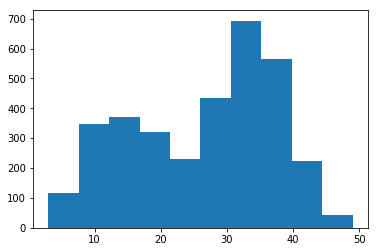

In [185]:
hist(table_test['num_data_points'])

(array([37., 40., 33., 43., 27., 42., 82., 80., 60., 13.]),
 array([ 3. ,  7.1, 11.2, 15.3, 19.4, 23.5, 27.6, 31.7, 35.8, 39.9, 44. ]),
 <a list of 10 Patch objects>)

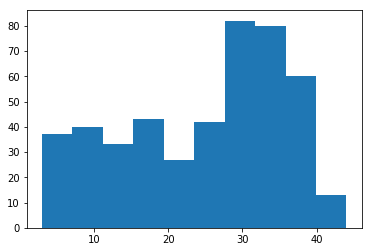

In [188]:
hist(FP_table['num_data_points'])

In [194]:
output = FP_IIL
plot_ind = 0
num_points = output[plot_ind]['num_data_points']-1
#-1 is temporary and will be removed once I fix preprocess

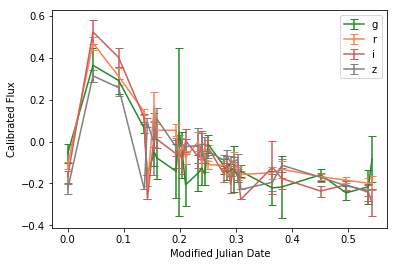

In [195]:
MJD = output['DATA'][plot_ind,:num_points,0]

g_FLUXCAL = output['DATA'][plot_ind,:num_points,1]
r_FLUXCAL = output['DATA'][plot_ind,:num_points,2]
i_FLUXCAL = output['DATA'][plot_ind,:num_points,3]
z_FLUXCAL = output['DATA'][plot_ind,:num_points,4]

g_err = output['DATA'][plot_ind,:num_points,5]
r_err = output['DATA'][plot_ind,:num_points,6]
i_err = output['DATA'][plot_ind,:num_points,7]
z_err = output['DATA'][plot_ind,:num_points,8]

plt.errorbar(MJD, g_FLUXCAL, g_err, capsize = 4, label='g',color = 'forestgreen') 
plt.errorbar(MJD, r_FLUXCAL, r_err, capsize = 4, label='r',color = 'coral')
plt.errorbar(MJD, i_FLUXCAL, i_err, capsize = 4, label='i', color = 'indianred')
plt.errorbar(MJD, z_FLUXCAL, z_err, capsize = 4, label='z', color = 'gray')
plt.xlabel('Modified Julian Date')
plt.ylabel('Calibrated Flux')

plt.legend()
plt.show()